# 某奶茶店评价数据分析
本实验通过爬虫技术对某团网的某家奶茶店数据进行爬取，共获取约1200条评价数据，包括评价文本及评价时间两个字段。通过对收集的数据进行预处理，同时进行数据可视化，发掘该奶茶店的基本运营情况。最后利用LDA对评价数据存在主题进行发掘和利用paddleNLP的taskflow进行情感分析一键预测，对该奶茶店运营存在问题深入剖析。
 


# 0 所需环境

In [1]:
!pip install pyLDAvis
!pip install wordcloud

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 10.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 11.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.5/379.5 kB 5.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 12.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.4 MB/s eta 0:00:00
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136882 sha256=880ccbc30fc0a9fce1459459adc663cbb3000adbe82f7a220557a05357dbe922
  Stored in directory: /home/aistudio/.cache/pip/wheels/8c/61/7a/e7039e

In [2]:
# 读取/预处理数据库
import pandas as pd
import numpy as np
import time

# 可视化工具
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator # 词云可视化

# 分词工具
import jieba
import jieba.posseg as psg
import re

# 文本特征提取工具
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# LDA主题模型可视化
import pyLDAvis
import pyLDAvis.sklearn
import paddlenlp


# 1 数据读取与预处理

## 1.1 数据读取

In [3]:
data = pd.read_excel("data/data155443/xicha_meituan_data.xlsx")
dic_file = r"file/dict.txt"            #特定词表
stop_file = r"file/cn_stopwords.txt"   #停用词表

## 1.2 数据预处理

In [4]:
# 去除无内容的评价
data = data.dropna()
data.head(5)

comment   comment_time
0  年后一直心心念喜茶的蛋糕，今天终于有时间过去一趟，工作日的蛋糕品种有点少，没有我最爱的青提蛋...  1648282990264
1  这次就餐整体感觉很赞，比较满意的方面有：性价比。好喝，不错，就是排队太多人了，自从降价以后，...  1650933910610
2  还行吧 30元2杯 还是可以的 「#套餐：时令鲜果·满瓶桑桑饮品套餐」「#燕麦豆豆蛋糕」好喝...  1644496158802
3             太糟心了，下了三个订单，结果等了一个小时，说还只给我下了一单，又重新排队……  1656388467930
4               「#套餐：解腻CP·双杯轻芒芒」很不错！很好喝 就是等待时间特别特别长。  1655632398772

### 1.2.1 文本数据预处理
文本数据预处理部分主要是对文本进行分词和词频统计，支撑后续工作

In [5]:
# 分词函数
def chinese_word_cut(mytext):
    jieba.load_userdict(dic_file)      #导入特定词表
    jieba.initialize()                #初始化
    try:
        stopword_list = open(stop_file,encoding ='utf-8')    #导入停用词表
    except:
        stopword_list = []
        print("error in stop_file")
    stop_list = []
    flag_list = ['n','nz','vn','a','an','ad','i']   # 词性标注条件
    for line in stopword_list:        #处理导入的停用表的格式
        line = re.sub(u'\n|\\r', '', line)
        stop_list.append(line)

    word_list = []
    # 采用jieba进行分词、词性筛选、去停用词
    seg_list = psg.cut(mytext,use_paddle=True)
    for seg_word in seg_list:
        word = seg_word.word  
        find = 0
        if seg_word.flag == 'x':
            find=1
        for stop_word in stop_list:
            if stop_word == word :    
                    find = 1
                    break
        if find == 0 : # and seg_word.flag in flag_list
            word_list.append(word)      
    return (" ").join(word_list)

# 计算分词后文本的词频
def count_frequencies(word_list):
    freq = dict()
    for sentence in word_list:
        for w in sentence.split(' '):
            if w not in freq.keys():
                freq[w] = 1
            else:
                freq[w] += 1
    return freq

In [6]:
data["cutted_comment"] = data.comment.apply(chinese_word_cut)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.813 seconds.
Prefix dict has been built successfully.


In [7]:
freq = count_frequencies(data["cutted_comment"])
freq = sorted(freq.items(),key=lambda x:x[1],reverse=True)
freq[:15]

[('好喝', 197),
 ('不错', 121),
 ('喝', 107),
 ('味道', 96),
 ('排队', 93),
 ('喜欢', 64),
 ('茶', 64),
 ('真的', 62),
 ('哈哈哈', 60),
 ('喜茶', 54),
 ('点', 50),
 ('太', 45),
 ('店', 45),
 ('套餐', 44),
 ('口味', 42)]

In [8]:
len(freq)

1730

In [9]:
# 去除过短的评论
t_data = data[data['cutted_comment'].str.len()>5]
t_data = t_data.reset_index().drop(columns='index')

### 1.2.2 评价时间字段数据预处理
获取的评价时间数据是13位的时间戳，需要转换为自己需要的日期格式

In [10]:
_date=[]
_date_month=[]
_date_day=[]
_time=[]
_time_hour=[]
for i in t_data['comment_time']:
    arr=time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(i/1000)).split(' ')
    _date.append(arr[0])
    _date_month.append(arr[0].split('-')[1])
    _date_day.append(arr[0].split('-')[2])
    _time.append(arr[1])
    _time_hour.append(arr[1].split(':')[0])

In [11]:
t_data.insert(2,value=_date_month,column='_date_month')
t_data.insert(3,value=_date_day,column='_date_day')
t_data.insert(4,value=_time_hour,column='_time_hour')

In [12]:
t_data.head(5)

comment   comment_time  \
0  年后一直心心念喜茶的蛋糕，今天终于有时间过去一趟，工作日的蛋糕品种有点少，没有我最爱的青提蛋...  1648282990264   
1  这次就餐整体感觉很赞，比较满意的方面有：性价比。好喝，不错，就是排队太多人了，自从降价以后，...  1650933910610   
2  还行吧 30元2杯 还是可以的 「#套餐：时令鲜果·满瓶桑桑饮品套餐」「#燕麦豆豆蛋糕」好喝...  1644496158802   
3             太糟心了，下了三个订单，结果等了一个小时，说还只给我下了一单，又重新排队……  1656388467930   
4               「#套餐：解腻CP·双杯轻芒芒」很不错！很好喝 就是等待时间特别特别长。  1655632398772   

  _date_month _date_day _time_hour  \
0          03        26         16   
1          04        26         08   
2          02        10         20   
3          06        28         11   
4          06        19         17   

                                      cutted_comment  
0  年 心 心念 喜茶 蛋糕 终于 时间 一趟 工作日 蛋糕 品种 少 最爱 青提 蛋糕 吃 两...  
1  就餐 整体 感觉 赞 比较满意 性价比 好喝 不错 排队 太多人 降价 第一次 喝 降价 性...  
2  还行 30 元 杯 套餐 时令 鲜果 满瓶桑桑 饮品 套餐 燕麦 豆豆 蛋糕 好喝 推荐 试...  
3                              太 糟心 三个 订单 小时 说 一单 排队  
4              套餐 解 腻 CP 双杯 轻 芒 芒 不错 好喝 等待时间 特别 特别 长

### 1.2.3 基于paddleNLP.TaskFlow评价情感分析

In [13]:
sa = paddlenlp.Taskflow('sentiment_analysis')
sentiment_analysis_data = sa(t_data['comment'].to_list())
sentiment_analysis_data_df = pd.DataFrame(sentiment_analysis_data)
sentiment_analysis_data_df.head(5)

100%|██████████| 14258/14258 [00:04<00:00, 3372.15it/s]
W1231 10:01:29.191386   221 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W1231 10:01:29.195596   221 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.
100%|██████████| 954280/954280 [02:29<00:00, 6402.58it/s] 
[2022-12-31 10:04:09,939] [    INFO] - Converting to the inference model cost a little time.
[2022-12-31 10:04:20,766] [    INFO] - The inference model save in the path:/home/aistudio/.paddlenlp/taskflow/sentiment_analysis/bilstm/static/inference


text     label     score
0  年后一直心心念喜茶的蛋糕，今天终于有时间过去一趟，工作日的蛋糕品种有点少，没有我最爱的青提蛋...  positive  0.992167
1  这次就餐整体感觉很赞，比较满意的方面有：性价比。好喝，不错，就是排队太多人了，自从降价以后，...  positive  0.992988
2  还行吧 30元2杯 还是可以的 「#套餐：时令鲜果·满瓶桑桑饮品套餐」「#燕麦豆豆蛋糕」好喝...  positive  0.991835
3             太糟心了，下了三个订单，结果等了一个小时，说还只给我下了一单，又重新排队……  negative  0.965662
4               「#套餐：解腻CP·双杯轻芒芒」很不错！很好喝 就是等待时间特别特别长。  positive  0.980085

In [14]:
t_data['label'] = sentiment_analysis_data_df['label']
t_data['score'] = sentiment_analysis_data_df['score']

In [15]:
# 保存一下
t_data.to_excel('file/data.xlsx',index=False,encoding='utf8')
t_data.head(5)

comment   comment_time  \
0  年后一直心心念喜茶的蛋糕，今天终于有时间过去一趟，工作日的蛋糕品种有点少，没有我最爱的青提蛋...  1648282990264   
1  这次就餐整体感觉很赞，比较满意的方面有：性价比。好喝，不错，就是排队太多人了，自从降价以后，...  1650933910610   
2  还行吧 30元2杯 还是可以的 「#套餐：时令鲜果·满瓶桑桑饮品套餐」「#燕麦豆豆蛋糕」好喝...  1644496158802   
3             太糟心了，下了三个订单，结果等了一个小时，说还只给我下了一单，又重新排队……  1656388467930   
4               「#套餐：解腻CP·双杯轻芒芒」很不错！很好喝 就是等待时间特别特别长。  1655632398772   

  _date_month _date_day _time_hour  \
0          03        26         16   
1          04        26         08   
2          02        10         20   
3          06        28         11   
4          06        19         17   

                                      cutted_comment     label     score  
0  年 心 心念 喜茶 蛋糕 终于 时间 一趟 工作日 蛋糕 品种 少 最爱 青提 蛋糕 吃 两...  positive  0.992167  
1  就餐 整体 感觉 赞 比较满意 性价比 好喝 不错 排队 太多人 降价 第一次 喝 降价 性...  positive  0.992988  
2  还行 30 元 杯 套餐 时令 鲜果 满瓶桑桑 饮品 套餐 燕麦 豆豆 蛋糕 好喝 推荐 试...  positive  0.991835  
3                              太 糟心 三个 订单 小时 说 一单 排队  negative  0.965662  
4              套餐 解 腻 CP 双杯 轻 芒 芒 不错 好喝 等待时间 特别 特别 长  positive  0.980085

In [16]:
t_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   comment         481 non-null    object 
 1   comment_time    481 non-null    int64  
 2   _date_month     481 non-null    object 
 3   _date_day       481 non-null    object 
 4   _time_hour      481 non-null    object 
 5   cutted_comment  481 non-null    object 
 6   label           481 non-null    object 
 7   score           481 non-null    float64
dtypes: float64(1), int64(1), object(6)
memory usage: 30.2+ KB


# 2 数据可视化

## 2.1 词云图文本可视化

In [17]:
def plt_imshow(x, ax=None, show=True):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(x)
    ax.axis("off")
    if show: plt.show()
    return ax

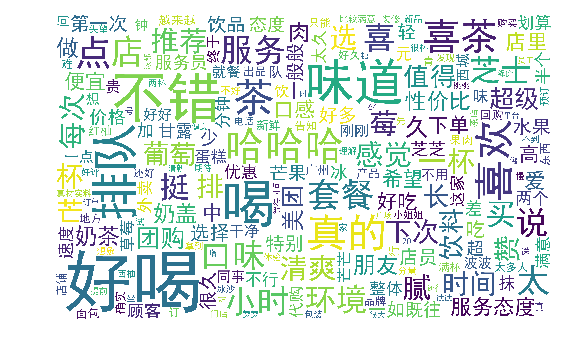

In [18]:
wcd = WordCloud(background_color='white',
    max_words=200,
    font_path = 'file/font/SIMHEI.TTF',
    mode="RGBA",
    max_font_size=180, 
    width = 1300,
    height = 800,
    scale=10
)
wcd.generate_from_frequencies(dict(freq))
ax=plt_imshow(wcd)
ax.figure.savefig('file/pic/wordcloud0.png',dpi=1000)

利用WordCloud库和处理后的评价数据进行词云图制作，得到下图，可以看到“好喝”、“不错”、“味道”等词在评价中经常出现，说明顾客在喜茶门店具有较好的服务感知满意度；“芝士”、“葡萄”、“芒果”、“草莓”等词也有较高的出现频率，说明服务产品中水果类饮品较多样顾客对该类商品有较深的印象；“环境”、“口味”、“味道”、“清爽”等词，说明顾客对门店服务支持设施和显性服务有一定的关注。

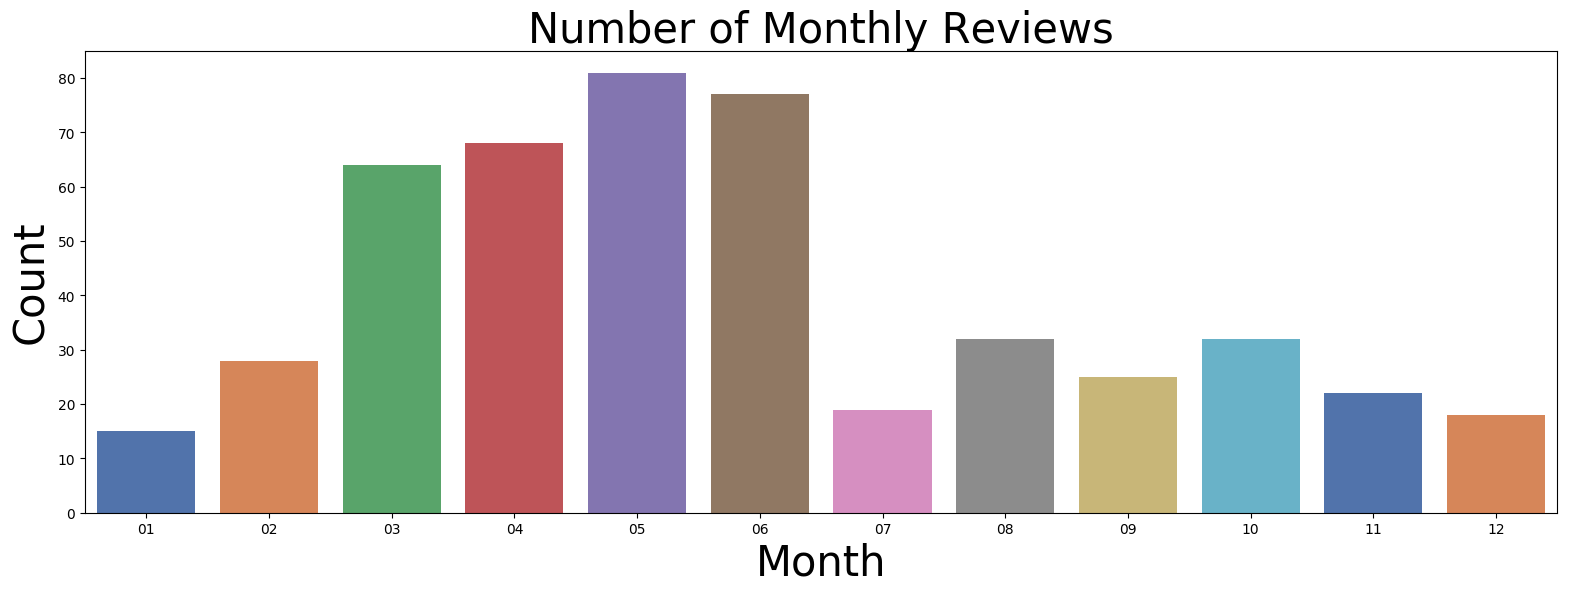

In [19]:
plt.figure(figsize=(19,6))
ax=sns.countplot(
    t_data['_date_month'],
    saturation =1,
    palette=sns.color_palette(palette='deep',desat=0.9,n_colors=12),
    )
plt.title('Number of Monthly Reviews',fontsize=30)
plt.xlabel('Month',fontsize=30)
plt.ylabel("Count",fontsize=30)
plt.savefig('file/pic/每月评价数.png',dpi=1000)


喜茶评价数据大多在上半年3到6月份，下半年评价数据较少。

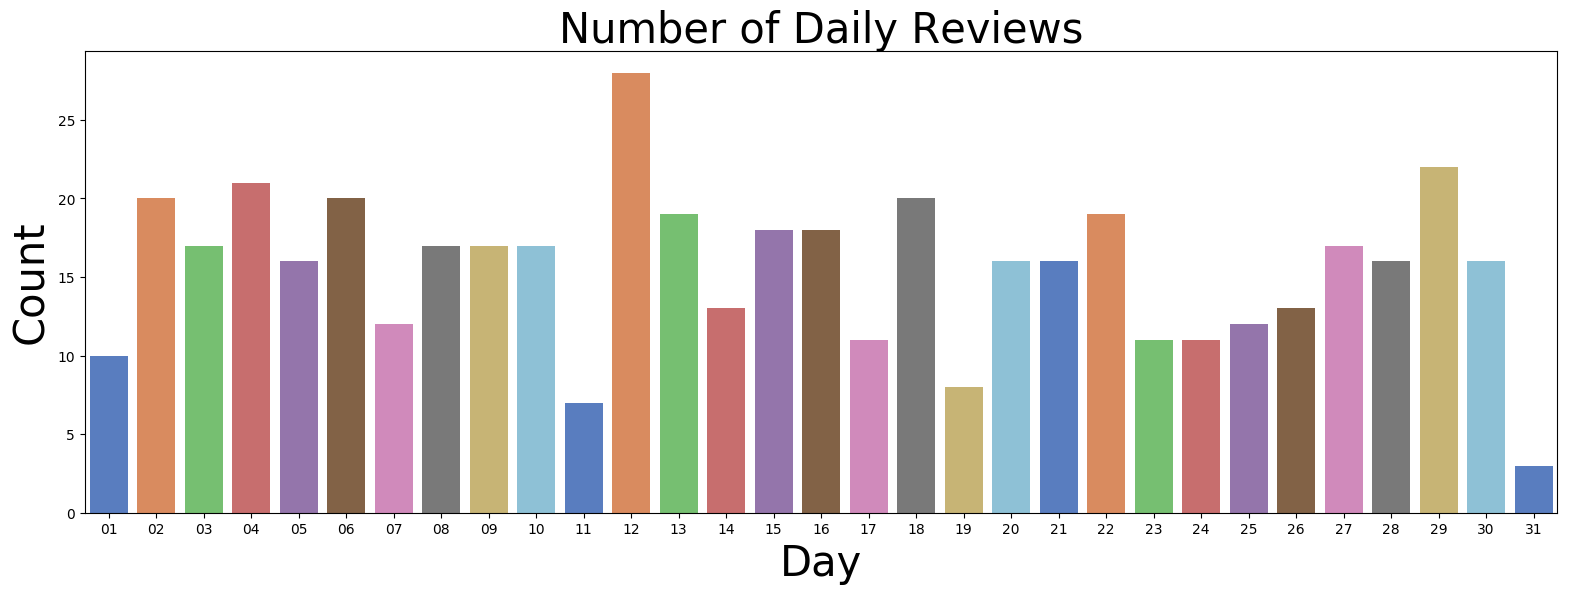

In [20]:
plt.figure(figsize=(19,6))
ax=sns.countplot(
    t_data['_date_day'],
    saturation =0.75,
    palette=sns.color_palette(palette='muted',desat=1,n_colors=10)
    )
plt.title('Number of Daily Reviews',fontsize=30)
plt.xlabel('Day',fontsize=30)
plt.ylabel("Count",fontsize=30)
plt.savefig('file/pic/一个月中每日评价数.png',dpi=1000)

对喜茶12个月中每天评价数据进行统计，得到下图。在每月12号、18号和29号评价数据较多；在1号、11号和19号较少，

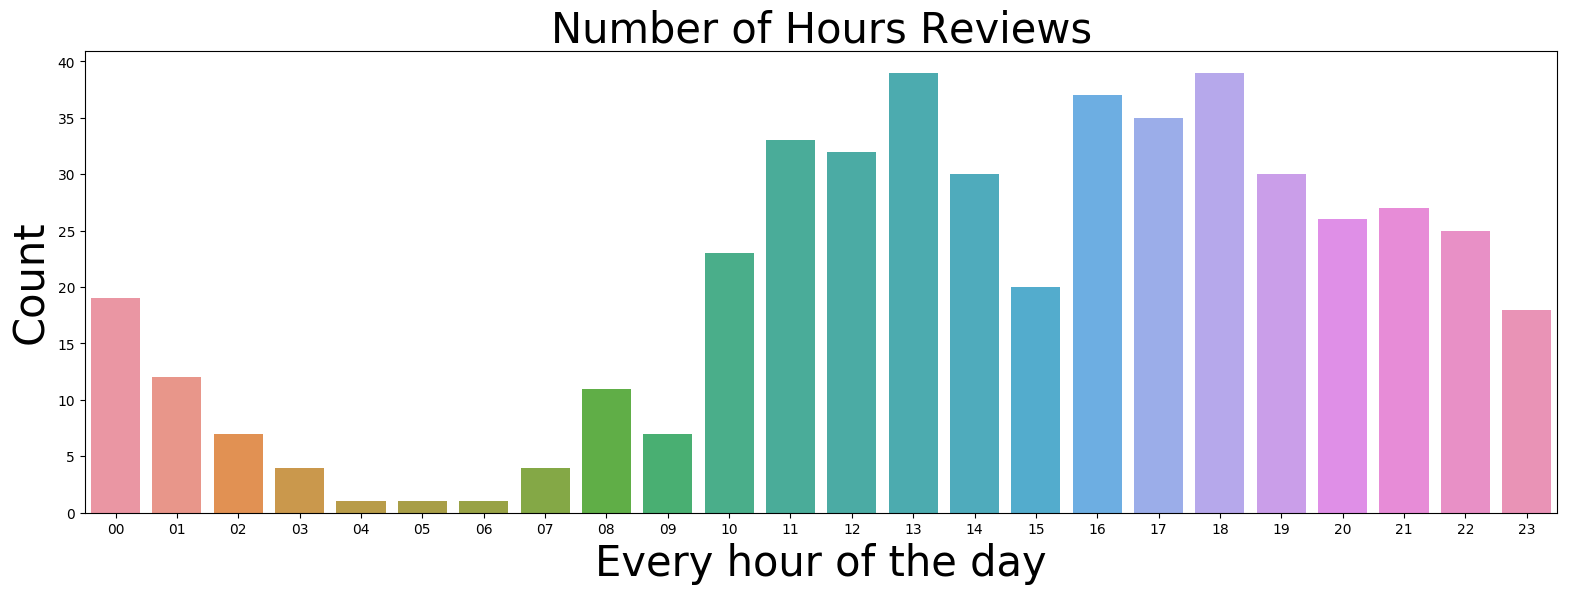

In [21]:
plt.figure(figsize=(19,6))
ax=sns.countplot(
    t_data['_time_hour']
    )
plt.title('Number of Hours Reviews',fontsize=30)
plt.xlabel('Every hour of the day',fontsize=30)
plt.ylabel("Count",fontsize=30)
plt.savefig('file/pic/一个天中24小时评价数.png',dpi=1000)

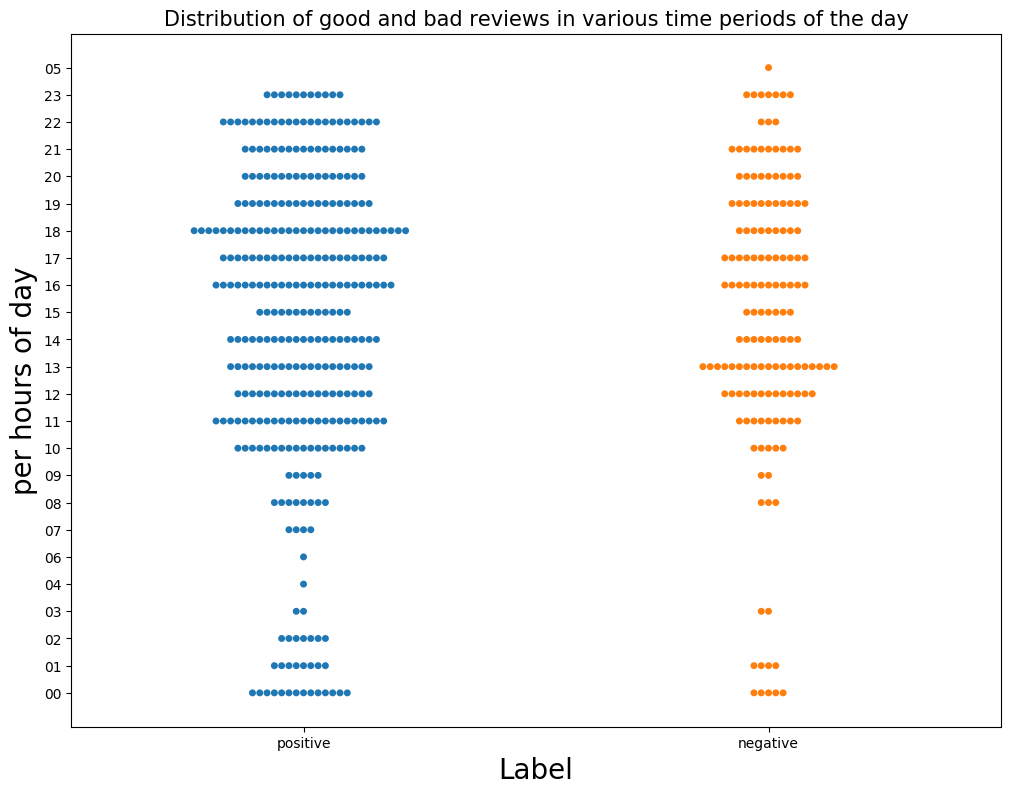

In [22]:
# 好坏评论每天各个时段散点图
plt.figure(figsize=(12,9))
sns.swarmplot(y=t_data['_time_hour'],x=t_data['label'])
plt.title('Distribution of good and bad reviews in various time periods of the day',fontsize=15)
plt.xlabel('Label',fontsize=20)
plt.ylabel('per hours of day',fontsize=20)
plt.savefig('file/pic/一天内各个时段好差评数据分布.png',dpi=1000)

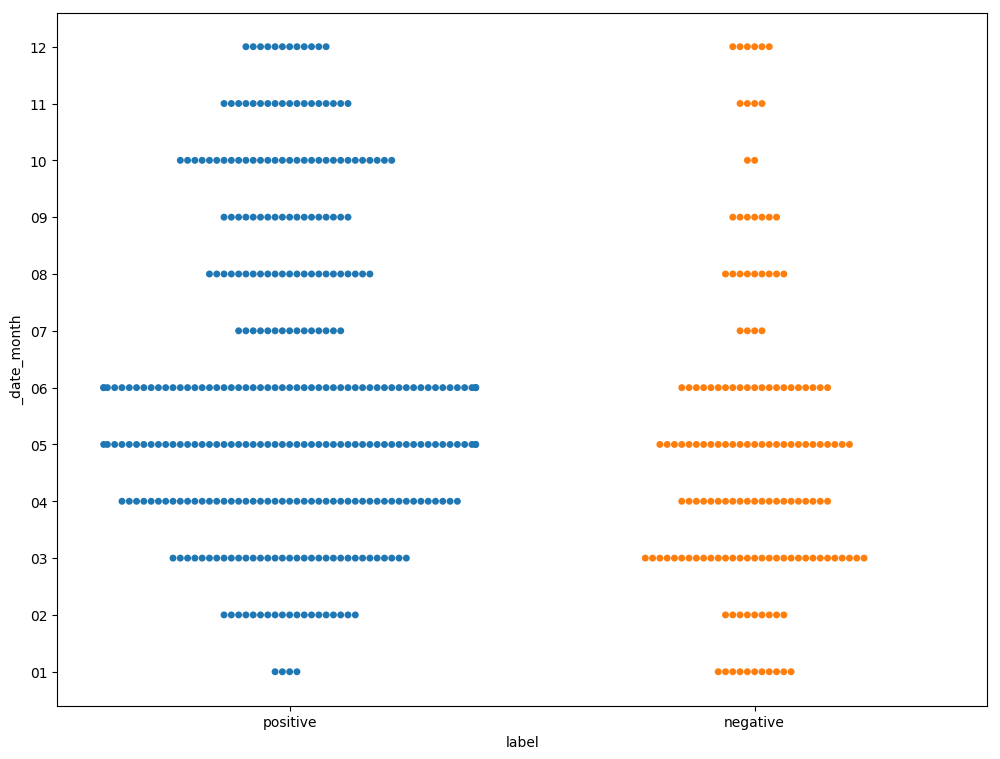

In [23]:
# 好坏评论每个月散点图
plt.figure(figsize=(12,9))
sns.swarmplot(y=t_data['_date_month'],x=t_data['label'])

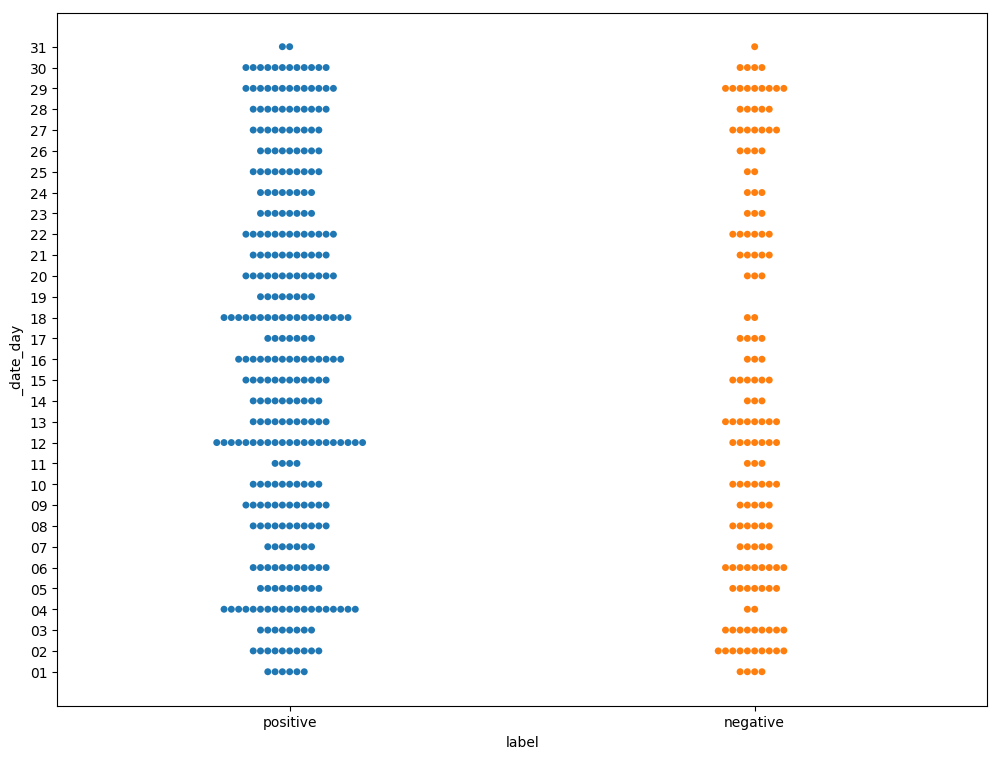

In [24]:
# 好坏评论每个月内散点图
plt.figure(figsize=(12,9))
sns.swarmplot(y=t_data['_date_day'],x=t_data['label'])

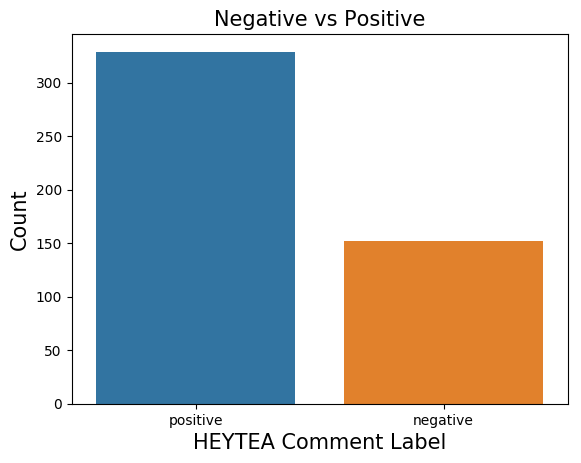

In [25]:
sns.countplot(t_data['label'])
plt.title(r"Negative vs Positive",fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.xlabel('HEYTEA Comment Label',fontsize=15)
plt.savefig('file/pic/评价积极与消极比较.png',dpi=1000)

In [26]:
print('消极评论占比',sum(t_data['label']=='negative')/len(t_data))

消极评论占比 0.316008316008316


In [27]:
# 消极评论词云图
freq_negative = count_frequencies(t_data[t_data['label']=='negative']['cutted_comment'])
freq_negative = sorted(freq_negative.items(),key=lambda x:x[1],reverse=True)
freq_negative[:15]

[('说', 34),
 ('喝', 34),
 ('好喝', 33),
 ('味道', 27),
 ('店', 24),
 ('小时', 21),
 ('排队', 20),
 ('点', 19),
 ('服务', 19),
 ('一杯', 18),
 ('葡萄', 17),
 ('做', 16),
 ('喜茶', 15),
 ('太', 14),
 ('感觉', 14)]

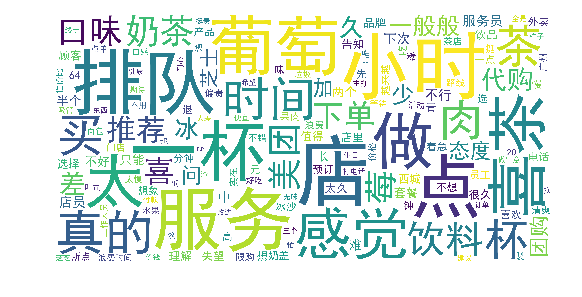

In [28]:
wcd = WordCloud(background_color='white',
    max_words=150,
    font_path = 'file/font/SIMHEI.TTF',
    mode="RGBA",
    max_font_size=160, 
    width = 1000,
    height = 500,
    scale=10)
wcd.generate_from_frequencies(dict(freq_negative[4:]))
ax=plt_imshow(wcd)
ax.figure.savefig('file/pic/wordcloud_negative.png',dpi=1000)

# 3 LDA模型主题挖掘

## 3.1 文本特征提取

In [29]:
n_features = 1000 #提取1000个特征词语
cv_vectorizer = CountVectorizer(max_df = 0.90, max_features=n_features, min_df = 5) #构建词袋数据结构
cv = cv_vectorizer.fit_transform(t_data.cutted_comment) # 将文本转换为词频矩阵
cv.toarray()

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## 3.2 LDA困惑度与主题数选择

In [30]:
plexs = []
n_max_topics = 50
for i in range(1,n_max_topics):
    print(i,end='..')
    lda = LatentDirichletAllocation(n_components=i,
                                    doc_topic_prior=1/i,
                                    topic_word_prior=1/i,
                                    learning_method='batch')
    lda.fit(cv)
    plexs.append(lda.perplexity(cv))

1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..

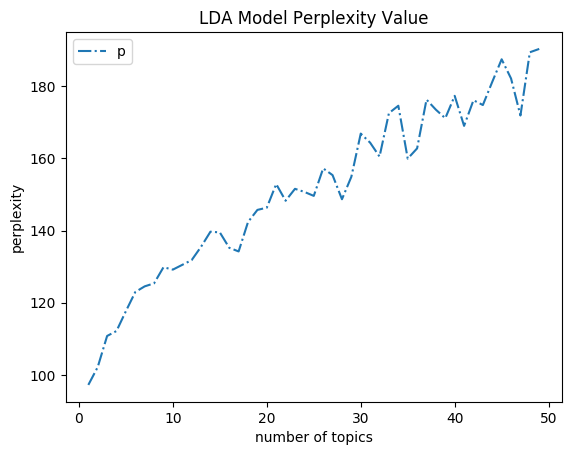

In [31]:
n_t=50#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t))
plt.plot(x,plexs[:n_t], linestyle='-.')
plt.xlabel("number of topics")
plt.ylabel("perplexity")
plt.legend(('perplexity_value'))
plt.title("LDA Model Perplexity Value")
plt.savefig('file/pic/PerplexityValue.png',dpi=1000)
plt.show()

## 3.3 LDA模型训练与模型结果

In [32]:
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics,max_iter=100,
                                    doc_topic_prior=1/n_topics,
                                    topic_word_prior=0.01,
                                    learning_method='batch')
lda.fit(cv)

LatentDirichletAllocation(doc_topic_prior=0.25, max_iter=100, n_components=4,
                          topic_word_prior=0.01)

关于LDA主题模型主题数的选择，可以参考文章https://zhuanlan.zhihu.com/p/106982034主题模型（三）：LDA主题个数选择


In [33]:
def print_top_words(model, feature_names, n_top_words):
    tword = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        topic_w = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(topic_w)
        print(topic_w)
    return tword

In [34]:
# 输出每个主题及其主题词
n_top_words = 15
cv_vectorizer_name = cv_vectorizer.get_feature_names()
topic_word = print_top_words(lda, cv_vectorizer_name, n_top_words)

Topic #0:
不错 套餐 环境 芝士 味道 服务 清爽 口味 性价比 口感 奶盖 一般般 真的 甘露 服务态度
Topic #1:
小时 一杯 时间 排队 饮料 下单 好吃 喜茶 店员 葡萄 团购 奶茶 态度 半个 两个
Topic #2:
哈哈哈 好喝 真的 值得 推荐 喜欢 排队 朋友 特别 不行 太久 不用 一如既往 店里 回购
Topic #3:
好喝 味道 排队 喜茶 喜欢 超级 感觉 每次 希望 真的 水果 很久 葡萄 下次 美团


In [35]:
# LDA模型还可以用于文本分类
topics=lda.transform(cv)
topic = []
for t in topics:
    topic.append("Topic #"+str(list(t).index(np.max(t))))
t_data['概率最大的主题序号']=topic
t_data['每个主题对应概率']=list(topics)
t_data.to_excel("data_topic_test0.xlsx",index=False)


In [36]:
t_data.head(5)

comment   comment_time  \
0  年后一直心心念喜茶的蛋糕，今天终于有时间过去一趟，工作日的蛋糕品种有点少，没有我最爱的青提蛋...  1648282990264   
1  这次就餐整体感觉很赞，比较满意的方面有：性价比。好喝，不错，就是排队太多人了，自从降价以后，...  1650933910610   
2  还行吧 30元2杯 还是可以的 「#套餐：时令鲜果·满瓶桑桑饮品套餐」「#燕麦豆豆蛋糕」好喝...  1644496158802   
3             太糟心了，下了三个订单，结果等了一个小时，说还只给我下了一单，又重新排队……  1656388467930   
4               「#套餐：解腻CP·双杯轻芒芒」很不错！很好喝 就是等待时间特别特别长。  1655632398772   

  _date_month _date_day _time_hour  \
0          03        26         16   
1          04        26         08   
2          02        10         20   
3          06        28         11   
4          06        19         17   

                                      cutted_comment     label     score  \
0  年 心 心念 喜茶 蛋糕 终于 时间 一趟 工作日 蛋糕 品种 少 最爱 青提 蛋糕 吃 两...  positive  0.992167   
1  就餐 整体 感觉 赞 比较满意 性价比 好喝 不错 排队 太多人 降价 第一次 喝 降价 性...  positive  0.992988   
2  还行 30 元 杯 套餐 时令 鲜果 满瓶桑桑 饮品 套餐 燕麦 豆豆 蛋糕 好喝 推荐 试...  positive  0.991835   
3                              太 糟心 三个 订单 小时 说 一单 排队  negative  0.965662   
4              套餐 解 腻 CP 双杯 轻 芒 芒 不错 好喝 等待时间 特别 特别 长  positive  0.980085   

  概率最大的主题序号                                           每个主题对应概率  
0  Topic #0  [0.43541575274724575, 0.39366159194530664, 0.0...  
1  Topic #0  [0.6079481441187665, 0.016943757588184245, 0.0...  
2  Topic #0  [0.5705865897290745, 0.018104453987739317, 0.3...  
3  Topic #1  [0.06250000000000071, 0.8089212775512773, 0.06...  
4  Topic #0  [0.4642857142857102, 0.03571428571428637, 0.46...

## 3.4 LDA模型结果可视化

In [37]:
pyLDAvis.enable_notebook()
pic = pyLDAvis.sklearn.prepare(lda, cv,cv_vectorizer)
pyLDAvis.display(pic)
pyLDAvis.save_html(pic, 'file/pic/lda_pass'+str(n_topics)+'.html')
pyLDAvis.display(pic)
#去工作路径下找保存好的html文件

# 4 总结
结合LDA主题挖掘与情感分析统计的结果，可以得出喜茶在广州地区的门店主要的运营问题是排队时间过长的结论，同时可以推断该问题在中午的13点与下午的17点经常频发。